## Fine Tuning Xception for ICB

In [1]:
import gc
import lib
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras as kr
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import itertools

%matplotlib inline

[13:58:51] Library functions loaded.


[14:11:41] Loaded custom functions.
[14:11:41] Loading regular data sets...
Found 248 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
[14:11:41] Loading augmented data sets...
Found 248 images belonging to 2 classes.
[14:11:41] Loaded existing dataset & performed data augmentation.
[14:11:41] Displaying first 1 batches of the augmented_train_set VS train_set:


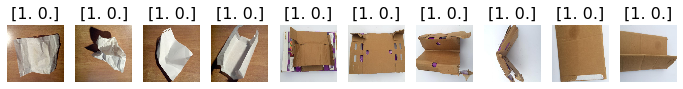

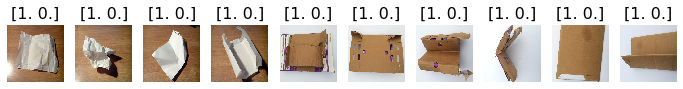

[14:11:42] Data Augmentation & Dataset loading completed!
	Time taken:  1.3093974590301514


In [12]:
# Implementation Dependant Globals
REQUIRED_DIMENSIONS = (299, 299)
TRAIN_BATCH_SIZE  = 10
VALIDATION_BATCH_SIZE = 10
TEST_BATCH_SIZE = 10
N_AUG_VS_TEST = 1
CLASSES = ["biomass", "non_biomass"]

# Import dataset
%run DataAugmentation.ipynb 

#### Fetch & Download Xception model

In [3]:
xception = kr.applications.xception
xception_model = xception.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=REQUIRED_DIMENSIONS+(3,)
)
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Building and Compiling

In [4]:
# Ease of Access
GlobalAveragePooling2D, Model, Dropout, Flatten, Dense = kr.layers.GlobalAveragePooling2D, kr.models.Model, kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

# Construct the Head Model
head_model = xception_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(200,activation='relu')(head_model)
head_model = Dropout(0.4)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# place the head model on top of the base model (this will become the actual model we will train)
model = Model(inputs=xception_model.input, outputs=head_model)

# Freeze all the layers
for layer in xception_model.layers:
    layer.trainable = False

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

#### Warmup Training

In [5]:
# Compile Module
model.compile(
    loss='binary_crossentropy',
    optimizer=kr.optimizers.Nadam(lr=0.0001),
    metrics=['accuracy']
)

# Train the head of the module (Our Layers)
t1_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

Epoch 1/30
25/24 [==============================] - 21s 822ms/step - loss: 0.7693 - accuracy: 0.4597 - val_loss: 6.0732 - val_accuracy: 0.5625
Epoch 2/30
25/24 [==============================] - 18s 729ms/step - loss: 0.7307 - accuracy: 0.4960 - val_loss: 6.0535 - val_accuracy: 0.5625
Epoch 3/30
25/24 [==============================] - 18s 724ms/step - loss: 0.7355 - accuracy: 0.5121 - val_loss: 5.7363 - val_accuracy: 0.5903
Epoch 4/30
25/24 [==============================] - 18s 720ms/step - loss: 0.7020 - accuracy: 0.5806 - val_loss: 6.0511 - val_accuracy: 0.5625
Epoch 5/30
25/24 [==============================] - 18s 716ms/step - loss: 0.6629 - accuracy: 0.6331 - val_loss: 5.5364 - val_accuracy: 0.5903
Epoch 6/30
25/24 [==============================] - 18s 718ms/step - loss: 0.6714 - accuracy: 0.5968 - val_loss: 5.9614 - val_accuracy: 0.5694
Epoch 7/30
25/24 [==============================] - 18s 717ms/step - loss: 0.6426 - accuracy: 0.6895 - val_loss: 5.7825 - val_accuracy: 0.5903

Predicting...
Predcitions completed! # 70
              precision    recall  f1-score   support

     biomass       1.00      0.06      0.11        35
 non_biomass       0.51      1.00      0.68        35

    accuracy                           0.53        70
   macro avg       0.76      0.53      0.39        70
weighted avg       0.76      0.53      0.39        70

Normalized confusion matrix


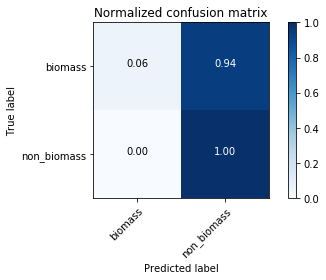

In [13]:
gc.collect()

# Make sure everything is okay
test_set.reset()
test_set.batch_size = 1
test_set.shuffle = False

# Can only handle 5 batch size perdictions (PAULO's GPU)
print("Predicting...")
img, label = next(test_set)
predictions = model.predict(img, verbose=0)

for i in range(len(test_set)-1):
    img, label = next(test_set)
    new_predictions = model.predict(img, verbose=0)
    predictions = np.concatenate((predictions, new_predictions))

print("Predcitions completed! #", len(predictions))
# Print out scikit report
normalised_predictions = np.argmax(predictions, axis=1)
print(lib.classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Final Training

In [14]:
# Reset validaiton & train set generators
train_set.reset()
validation_set.reset()

# Now that the head FC layers have been trained/initialized, lets
# Unfreeze the final set of CONV layers and make them trainable
for layer in xception_model.layers:
	layer.trainable = True

    
# Recompile module for changes to take effect, now using SGD with very small learning rate
model.compile(
    loss="binary_crossentropy", 
    optimizer="nadam", 
    metrics=["accuracy"]
)    

# Train the whole module
t2_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1,
    shuffle=True
)

Epoch 1/30
25/24 [==============================] - 28s 1s/step - loss: 0.6565 - accuracy: 0.7621 - val_loss: 2.6712 - val_accuracy: 0.5486
Epoch 2/30
25/24 [==============================] - 26s 1s/step - loss: 0.6979 - accuracy: 0.5161 - val_loss: 1.5265 - val_accuracy: 0.3333
Epoch 3/30
25/24 [==============================] - 27s 1s/step - loss: 0.6704 - accuracy: 0.6532 - val_loss: 0.7816 - val_accuracy: 0.4375
Epoch 4/30
25/24 [==============================] - 28s 1s/step - loss: 0.5735 - accuracy: 0.7944 - val_loss: 8.0609 - val_accuracy: 0.4514
Epoch 5/30
25/24 [==============================] - 27s 1s/step - loss: 0.6963 - accuracy: 0.5363 - val_loss: 5.8668 - val_accuracy: 0.5486
Epoch 6/30
25/24 [==============================] - 28s 1s/step - loss: 0.6832 - accuracy: 0.5524 - val_loss: 0.6891 - val_accuracy: 0.6528
Epoch 7/30
25/24 [==============================] - 28s 1s/step - loss: 0.6769 - accuracy: 0.5484 - val_loss: 0.6545 - val_accuracy: 0.7569
Epoch 8/30
25/24 [==

Predicting...
Predcitions completed! # 70
              precision    recall  f1-score   support

     biomass       0.49      0.94      0.64        35
 non_biomass       0.00      0.00      0.00        35

    accuracy                           0.47        70
   macro avg       0.24      0.47      0.32        70
weighted avg       0.24      0.47      0.32        70

Normalized confusion matrix


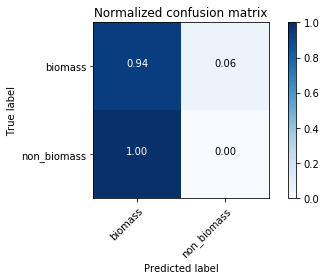

In [15]:
gc.collect()

# Make sure everything is okay
test_set.reset()
test_set.batch_size = 1
test_set.shuffle = False

# Can only handle 5 batch size perdictions (PAULO's GPU)
print("Predicting...")
img, label = next(test_set)
predictions = model.predict(img, verbose=0)

for i in range(len(test_set)-1):
    img, label = next(test_set)
    new_predictions = model.predict(img, verbose=0)
    predictions = np.concatenate((predictions, new_predictions))

print("Predcitions completed! #", len(predictions))
# Print out scikit report
normalised_predictions = np.argmax(predictions, axis=1)
print(lib.classification_report(test_set.classes, normalised_predictions, target_names=CLASSES))
lib.plot_confusion_matrix(test_set.classes, normalised_predictions, CLASSES)

#### Visualising Training History

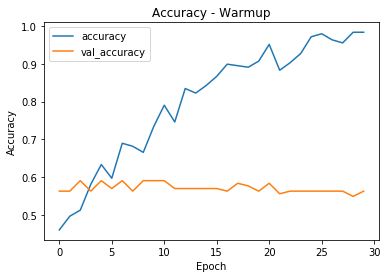

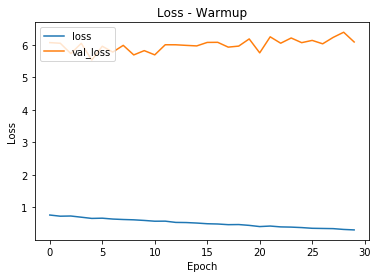

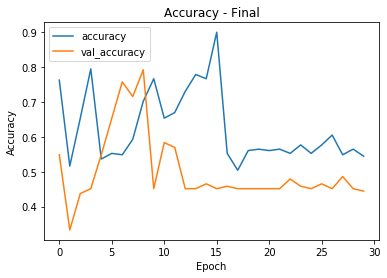

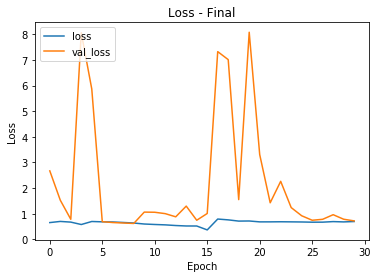

In [16]:
t1_history.plot_title = "Warmup"
t2_history.plot_title = "Final"

global_history = [t1_history, t2_history]

for history in global_history:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title("Accuracy - " + history.plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss - " + history.plot_title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [17]:
model.save('app\\trained_models\\Xception')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: app\trained_models\Xception\assets
